# Vincent LIU MVA - HW3 LASSO CONVEX OPTIMIZATION

Theorical results and observations are detailled in the report.

In [1]:
# Import libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style('whitegrid')

In [2]:
# Utility functions
def is_feasible(Q, p, A, b, v):
    return (np.dot(A, v) >= b).sum() == 0

def f0(Q, p, A, b, v):
    return np.dot(np.dot(v, Q), v) + np.dot(p, v)

def f(Q, p, A, b, v, t):
    return t * f0(Q, p, A, b, v) - np.sum(np.log(-np.dot(A, v) + b))

In [3]:
def backtracking_line_search(Q, p, A, b, v, t,
                             newton_step, newton_decrement,
                             alpha=0.1, beta=0.6):
    flag = 0
    step_size = 1
    f_v = f(Q, p, A, b, v, t)

    # Check that the solution is feasible, before evaluating the logarithm
    while not is_feasible(Q, p, A, b, v + step_size * newton_step):
        step_size *= beta
        
    diff = f(Q, p, A, b, v + step_size * newton_step, t) - (f_v - alpha * step_size * newton_decrement)
    while diff > 0:
        step_size *= beta
        diff = f(Q, p, A, b, v + step_size * newton_step, t) - (f_v - alpha * step_size * newton_decrement)
        # Avoid infinite loop
        if diff < 1e-16:
            flag = 1

    return step_size, flag

In [14]:
def centering_step(Q, p, A, b, t, v, eps, verbose=False):

    # Precompute A_i^T A_i outer product for the hessian
    hess_phi_num = np.zeros((A.shape[0], A.shape[1], A.shape[1]))
    for i in range(A.shape[0]):
        hess_phi_num[i] = np.outer(A[i, :], A[i, :].T)

    # Output information
    v_inner_seq = []
    v_inner_seq.append(v)
    n_inner_eps = 0
    newton_decrements_inner = []
    
    while True:
        grad_phi_denom = (-1. / (np.dot(A, v) + b))

        # Compute gradient
        grad_f = t * (2 * np.dot(Q, v) + p) + np.dot(A.T, grad_phi_denom)

        # Compute hessian
        hess_f = 2 * t * Q + np.tensordot(np.power(grad_phi_denom, 2), hess_phi_num, 1)

        # Compute newton step and newton decrement
        inv_hess_f = np.linalg.inv(hess_f)
        newton_step = - np.dot(inv_hess_f, grad_f)
        newton_decrement = np.dot(grad_f, -newton_step)

        # Stopping criterion
        if newton_decrement / 2 <= eps:
            break
            
        # Backtracking line search
        step_size, flag = backtracking_line_search(Q, p, A, b, v, t,
                                             newton_step, newton_decrement)
        if flag:
            break
            
        # Update parameters
        v = v + newton_step * step_size
        
        # Update output information
        v_inner_seq.append(v)
        n_inner_eps += 1
        newton_decrements_inner.append(newton_decrement)
               
        if verbose:
            print("Inner iteration: {:02d} | f(v) = {:.8f} | Newton decrement = {:.2f}".format(n_inner_eps, 
                                                                        f0(Q, p, A, b, v),
                                                                        newton_decrement))
        
    return v_inner_seq, n_inner_eps, newton_decrements_inner

In [15]:
def barr_method(Q, p, A, b, v0, t, mu, eps, verbose=False):
    
    # Output Information
    v_inner_seq_list = []
    n_inner_eps_list = []
    n_outer_eps = 0
    v_outer_seq = []
    v = v0
    newton_decrements_outer = []
    
    while True:
        if verbose:
            print("Outer iteration: {}".format(n_outer_eps))
            
        # Centering step
        v_inner_seq, n_inner_eps, newton_decrements_inner = centering_step(Q, p, A, b, t, v, eps, verbose)
        v = v_inner_seq[-1]

        # Stopping criterion
        if m / t < eps:
            break

        # ********************
        # Increment variables #
        # ******************* 
        t *= mu
        v_inner_seq_list += v_inner_seq
        n_inner_eps_list.append(n_inner_eps)
        n_outer_eps = n_outer_eps + 1
        v_outer_seq = v_outer_seq + v_inner_seq
        newton_decrements_outer.append(newton_decrements_inner)
    return v_outer_seq, n_outer_eps, v_inner_seq_list, n_inner_eps_list, newton_decrements_outer

## Parameters for experiments

In [16]:
# Dimension parameters
d = 100
n = 50
m = 2 * d

# Generate random data
np.random.seed(seed=1)
X = np.random.randn(n, d)
y = np.random.randn(n, )
lambd = 10

# Dual variable of the QP optimization problem
Q = np.eye(n, n) * 0.5
p = y
A = np.zeros((2 * d, n))
A[:d, :] = X.T
A[d:, :] = -X.T
b = lambd * np.ones((2 * d,))

# Barrier method parameters
eps = 1e-6
t = 1
v0 = np.zeros(n, )
assert (is_feasible(Q, p, A, b, v0))

## Sanity check

Verify that the code is actually running.

Verify that solution is good: KKT conditions are hold as well as strong duality.

In [17]:
def recover_w(X, y, lambd, v):
    is_sparse = ((np.abs(np.dot(v, X)) + 1e-3) < lambd).astype(int)
    not_sparse = (is_sparse == 0).astype(int)

    w = np.zeros(d,)
    X_bar = X[:, np.where(not_sparse)[0]]
    w[np.where(not_sparse)[0]] = np.linalg.inv(np.dot(X_bar.T, X_bar)).dot(X_bar.T).dot(v+y)
    return w

def compute_primal_objective(X, y, w, lambd):
    z = np.dot(X, w) - y
    return 0.5 * np.linalg.norm(z, 2)**2 + lambd * np.linalg.norm(w, 1)

def compute_dual_objective(v, y):
    return -0.5 * np.dot(v_star, v_star) - np.dot(y, v_star)

In [18]:
mu = 50
v_outer_seq, _, _, _, _ = barr_method(Q, p, A, b, v0, t, mu, eps, verbose=True)
v_star = v_outer_seq[-1]

# Recover w: see page 5 of the report
w = recover_w(X, y, lambd, v_star)
print('\nw has {} zero coefficients'.format((w == 0).sum()))

# Strong duality
primal_opt_value = compute_primal_objective(X, y, w, lambd)
dual_opt_value   = compute_dual_objective(v_star, y)
print('\nOptimal value is: {}'.format(primal_opt_value))
assert(np.abs(primal_opt_value - dual_opt_value) < 1e-1)

# Dual feasibility
assert(np.abs(np.linalg.norm(np.dot(X.T, v_star), np.inf) - lambd) < 1e-1)

Outer iteration: 0
Inner iteration: 01 | f(v) = -12.05294045 | Newton decrement = 16.27
Inner iteration: 02 | f(v) = -11.61381538 | Newton decrement = 0.07
Inner iteration: 03 | f(v) = -11.60259399 | Newton decrement = 0.00
Outer iteration: 1
Inner iteration: 01 | f(v) = -15.35874541 | Newton decrement = 612.62
Inner iteration: 02 | f(v) = -16.87647816 | Newton decrement = 228.89
Inner iteration: 03 | f(v) = -17.69519725 | Newton decrement = 71.32
Inner iteration: 04 | f(v) = -17.86262307 | Newton decrement = 6.81
Inner iteration: 05 | f(v) = -17.85415316 | Newton decrement = 0.03
Inner iteration: 06 | f(v) = -17.85393532 | Newton decrement = 0.00
Outer iteration: 2
Inner iteration: 01 | f(v) = -17.89609953 | Newton decrement = 2258.36
Inner iteration: 02 | f(v) = -17.92156934 | Newton decrement = 1347.93
Inner iteration: 03 | f(v) = -17.97376727 | Newton decrement = 1029.39
Inner iteration: 04 | f(v) = -18.00206245 | Newton decrement = 539.88
Inner iteration: 05 | f(v) = -18.02124354 

## Duality gap with respect to newton iterations

In [19]:
plot_dir = "plot"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

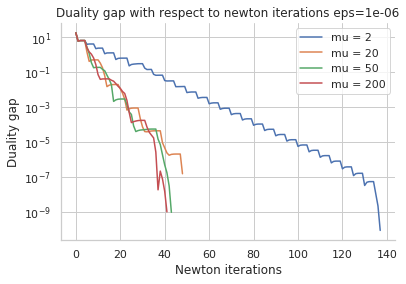

In [20]:
# Duality gap with respect to newton iterations
figure_name = "duality_gap_iterations.png"
plt.figure()

for mu in [2, 20, 50, 200]:
    v_outer_seq, _, v_inner_seq_list, _, _ = barr_method(Q, p, A, b, v0, t, mu, eps)

    dual_values = np.array([f0(Q, p, A, b, v) for v in v_outer_seq])
    
    duality_gap = np.abs(dual_values - dual_values[-1])
    iters = np.arange(len(duality_gap))
    
    plt.semilogy(range(len(duality_gap))[:-1], duality_gap[:-1], label='mu = {}'.format(mu))

plt.xlabel('Newton iterations')
plt.ylabel('Duality gap')
plt.title("Duality gap with respect to newton iterations eps={}".format(eps))
plt.legend()
sns.despine()
plt.savefig(os.path.join(plot_dir, figure_name))
plt.show()

## Newton decrement

The newton decrement quadratically decreases. I fixed the second outer iterations of the barrier method, and I plotted in semi log scale.

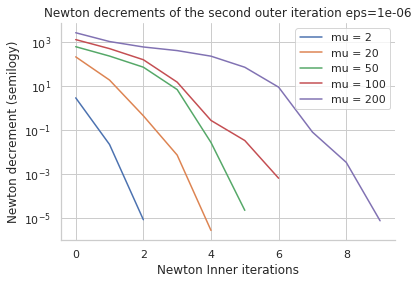

In [21]:
# Newton decrement with respect to inner newton iterations
figure_name = "newton_decrement_iterations.png"
plt.figure()

for mu in [2, 20, 50, 100, 200]:
    _, _, _, _, newton_decrements_outer = barr_method(Q, p, A, b, v0, t, mu, eps)

    plt.semilogy(range(len(newton_decrements_outer[1])), newton_decrements_outer[1], label='mu = {}'.format(mu))

plt.xlabel('Newton Inner iterations')
plt.ylabel('Newton decrement (semilogy)')
plt.title("Newton decrements of the second outer iteration eps={}".format(eps))
plt.legend()
sns.despine()
plt.savefig(os.path.join(plot_dir, figure_name))
plt.show()

## Newton iterations with respect to $\mu$

Newton iterations are not very sensitive to the value of $\mu$.

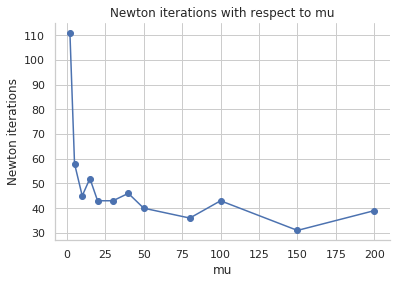

In [22]:
# Newton iterations with respect to mu
figure_name = "newton_iterations_mu.png"
plt.figure()

mu_list = [2, 5, 10, 15, 20, 30, 40, 50, 80, 100, 150, 200]
n_inner_eps_list = []

for mu in mu_list:
    _, _, _, n_inner_eps, _ = barr_method(Q, p, A, b, v0, t, mu, eps)
    n_inner_eps_list.append(sum(n_inner_eps))

plt.plot(mu_list, n_inner_eps_list, 'o-')
plt.xlabel('mu')
plt.ylabel('Newton iterations')
plt.title("Newton iterations with respect to mu")
sns.despine()
plt.savefig(os.path.join(plot_dir, figure_name))

# Impact of $\mu$ on $w$

The value of $\mu$ has no impact on final solution $w$

In [23]:
# Newton iterations with respect to mu
mu_list = [2, 5, 10, 15, 20, 30, 40, 50, 80, 100, 150, 200]

for mu in mu_list:
    v_outer_seq, _, _, _, _ = barr_method(Q, p, A, b, v0, t, mu, eps)
    v_star = v_outer_seq[-1]
    
    w = recover_w(X, y, lambd, v_star)
    primal_opt_value = compute_primal_objective(X, y, w, lambd)
    dual_opt_value   = compute_dual_objective(v_star, y)
    print("mu: {:02d} \nThe non zero coeffient of w are:\n {}\nprimal: {} | dual: {}\n\n".format(mu, w[np.where(w!=0)], 
                                                                         primal_opt_value,
                                                                        dual_opt_value))

mu: 02 
The non zero coeffient of w are:
 [ 0.03803553  0.02019551  0.00041892 -0.02328629  0.01985518  0.02915047
 -0.09483682]
primal: 18.040309911589837 | dual: 18.040309859435567


mu: 05 
The non zero coeffient of w are:
 [ 0.03803558  0.0201955   0.00041941 -0.02328624  0.01985524  0.02915052
 -0.09483671]
primal: 18.040309911606222 | dual: 18.040309768257018


mu: 10 
The non zero coeffient of w are:
 [ 0.03803558  0.0201955   0.00041946 -0.02328624  0.01985525  0.02915052
 -0.0948367 ]
primal: 18.040309911608563 | dual: 18.040309740823318


mu: 15 
The non zero coeffient of w are:
 [ 0.03803552  0.02019551  0.00041886 -0.0232863   0.01985517  0.02915046
 -0.09483684]
primal: 18.040309911588874 | dual: 18.04030987062459


mu: 20 
The non zero coeffient of w are:
 [ 0.03803557  0.02019551  0.00041929 -0.02328626  0.01985524  0.02915051
 -0.09483674]
primal: 18.040309911600794 | dual: 18.040309716156795


mu: 30 
The non zero coeffient of w are:
 [ 0.03803565  0.02019548  0.000420